#### Imports

In [2]:
import sys
from fitparse import FitFile
import os
import pandas as pd
import pymysql
from sqlalchemy import create_engine

#### Getting Path of all running moves

In [33]:
# Pau's activities
directory = 'C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves/'
running_files = []
for filename in os.listdir(directory):
    if filename.endswith('Running.fit') : 
        running_files.append(os.path.join(directory, filename))
        
# Armand's activities
directory = 'C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves_A/'
for filename in os.listdir(directory):
    if filename.endswith('Running.fit') : 
        running_files.append(os.path.join(directory, filename))
                
running_files[:5]

['C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves/Move_2017_07_02_11_46_40_Running.fit',
 'C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves/Move_2017_07_02_12_32_23_Running.fit',
 'C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves/Move_2017_07_19_19_49_13_Running.fit',
 'C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves/Move_2017_07_20_19_56_41_Running.fit',
 'C:/Users/Pau Sampietro/Desktop/IRONHACK/Movescount_data/Moves/Move_2017_07_24_18_17_34_Running.fit']

#### Creating DataFrame with all the data from the watch (Table: "records")

In [34]:
# Initializing categories we want to store
ls_move_code = []
ls_record_code = []
ls_altitude = []
ls_cadence = []
ls_distance = []
ls_enhanced_altitude = []
ls_enhanced_speed = []
ls_heart_rate = []
ls_position_lat = []
ls_position_long = []
ls_speed = []
ls_timestamp = []
ls_vertical_speed = []

move_code = 1
for filepath in running_files:
    fitfile = FitFile(filepath)
    # Get all data messages that are of type record
    record_code = 1
    for record in fitfile.get_messages('record'):
        # Go through all the data entries in this record and fill the lists
        ls_move_code.append(move_code)
        ls_record_code.append(record_code)
        ls_altitude.append(record.get_value('altitude'))
        ls_cadence.append(record.get_value('cadence'))
        ls_distance.append(record.get_value('distance'))
        ls_enhanced_altitude.append(record.get_value('enhanced_altitude'))
        ls_enhanced_speed.append(record.get_value('enhanced_speed'))
        ls_heart_rate.append(record.get_value('heart_rate'))
        ls_position_lat.append(record.get_value('position_lat'))
        ls_position_long.append(record.get_value('position_long'))
        ls_speed.append(record.get_value('speed'))
        ls_timestamp.append(record.get_value('timestamp'))
        ls_vertical_speed.append(record.get_value('vertical_speed'))
        record_code += 1
        
    move_code += 1

In [39]:
# Creating DF with all the records from all the moves
records = pd.DataFrame({'idmove': ls_move_code,
                        'idrecord': ls_record_code,
                        'latitude': ls_position_lat,
                        'longitude': ls_position_long,
                        'distance': ls_distance,
                        'altitude': ls_altitude,
                        'enhanced_altitude': ls_enhanced_altitude,
                        'cadence': ls_cadence,
                        'speed': ls_speed,
                        'enhanced_speed': ls_enhanced_speed,
                        'vertical_speed': ls_vertical_speed,
                        'heart_rate': ls_heart_rate,
                        'timestamp': ls_timestamp 
                       })

In [41]:
records.head()

,idmove,idrecord,latitude,longitude,distance,altitude,enhanced_altitude,cadence,speed,enhanced_speed,vertical_speed,heart_rate,timestamp
0,1,1,495379858.0,28361936.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02 09:46:42
1,1,2,495380072.0,28361805.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02 09:46:43
2,1,3,495380502.0,28361626.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02 09:46:45
3,1,4,495380729.0,28361554.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02 09:46:46
4,1,5,495380955.0,28361518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-07-02 09:46:47


In [42]:
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095712 entries, 0 to 3095711
Data columns (total 13 columns):
idmove               int64
idrecord             int64
latitude             float64
longitude            float64
distance             float64
altitude             float64
enhanced_altitude    float64
cadence              float64
speed                float64
enhanced_speed       float64
vertical_speed       float64
heart_rate           float64
timestamp            datetime64[ns]
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 307.0 MB


In [38]:
len(records)

3095712

In [43]:
records.isnull().sum()

idmove                     0
idrecord                   0
latitude             1652110
longitude            1652110
distance             1659830
altitude              164350
enhanced_altitude     164350
cadence              2622810
speed                 160138
enhanced_speed        160138
vertical_speed        187749
heart_rate           1578767
timestamp                  0
dtype: int64

#### Exporting to Google Cloud DB

In [44]:
# Importing credentials file and creating engine
import credentials

driver = credentials.driver
ip = credentials.ip
username = credentials.username
password = credentials.password
db = credentials.db

cs  = f'{driver}://{username}:{password}@{ip}/{db}'
engine = create_engine(cs)

In [45]:
records.to_sql(con=engine, name='records', if_exists='replace')

#### Obtaining general overview of all moves (Table: "moves")

In [47]:
# Initializing categories we want to store
ls_move_id = []
ls_start_time = []
ls_total_elapsed_time = []
ls_total_moving_time = []
ls_total_distance = []
ls_total_calories = []
ls_athlete = []

move_code = 1
for filepath in running_files:
    fitfile = FitFile(filepath)
    # Get message data with general information
    for elem in fitfile.get_messages('session'):
        ls_move_id.append(move_code)
        ls_start_time.append(elem.get_value('start_time'))
        ls_total_elapsed_time.append(elem.get_value('total_elapsed_time'))
        ls_total_moving_time.append(elem.get_value('total_moving_time'))
        ls_total_distance.append(elem.get_value('total_distance'))
        ls_total_calories.append(elem.get_value('total_calories'))
        if 'Moves_A' in filepath:
            ls_athlete.append('A')
        else:
            ls_athlete.append('P')

    move_code += 1

In [48]:
# Creating DF with all the general info of the moves
moves = pd.DataFrame({'move': ls_move_id,
                        'start_time': ls_start_time,
                        'elapsed_time': ls_total_elapsed_time,
                        'moving_time': ls_total_moving_time,
                        'distance': ls_total_distance,
                        'calories': ls_total_calories,
                        'athlete': ls_athlete
                       })

In [49]:
moves.head()

,move,start_time,elapsed_time,moving_time,distance,calories,athlete
0,1,2017-07-02 09:46:40,1787.960,1787.960,4019.0,670.0,P
1,2,2017-07-02 10:32:23,1856.488,1856.488,4995.0,585.0,P
2,3,2017-07-19 17:49:13,1356.937,1356.937,4374.0,602.0,P
3,4,2017-07-20 17:56:41,1014.037,1014.037,3005.0,365.0,P
4,5,2017-07-24 16:17:34,2522.062,2522.062,6540.0,760.0,P


In [50]:
moves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 7 columns):
move            820 non-null int64
start_time      820 non-null datetime64[ns]
elapsed_time    820 non-null float64
moving_time     820 non-null float64
distance        820 non-null float64
calories        808 non-null float64
athlete         820 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 44.9+ KB


#### Exporting to Google Cloud DB

In [52]:
moves.to_sql(con=engine, name='moves', if_exists='replace')

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

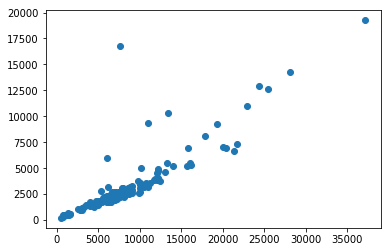

In [24]:
plt.scatter(moves['distance'], moves['moving_time'])

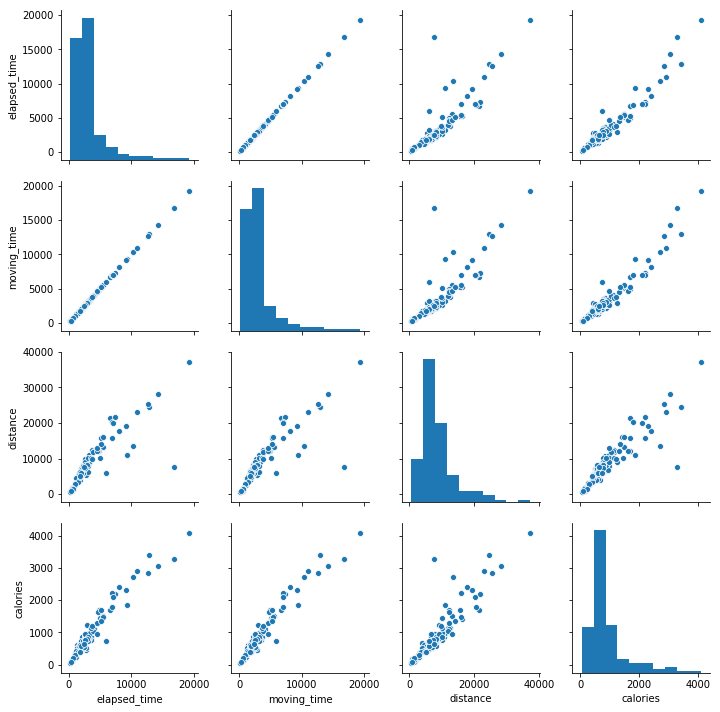

In [27]:
sns.pairplot(moves.drop(columns='move'))